In [2]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: D:\Lupheon\.venv\Scripts\python.exe -m pip install --upgrade pip


gpu 사용 확인 코드입니다

In [3]:
import torch
if torch.cuda.is_available():
    print(f'GPU 사용 가능: {torch.cuda.get_device_name(0)}')
else:
    print('GPU를 사용할 수 없습니다.')

GPU 사용 가능: NVIDIA GeForce RTX 5070


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 한글 폰트 설정 (matplotlib)
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
eth_data = np.load('preprocessed/ETH_1h.npy')
ada_data = np.load('preprocessed/ADA_1h.npy') 
xrp_data = np.load('preprocessed/XRP_1h.npy')
btc_data = np.load('preprocessed/BTC_1h.npy')  # 테스트용

print("=== 데이터 Shape 확인 ===")
print(f"ETH: {eth_data.shape}")
print(f"ADA: {ada_data.shape}")
print(f"XRP: {xrp_data.shape}")
print(f"BTC: {btc_data.shape}")

=== 데이터 Shape 확인 ===
ETH: (67081, 16)
ADA: (61290, 16)
XRP: (60874, 16)
BTC: (67081, 16)


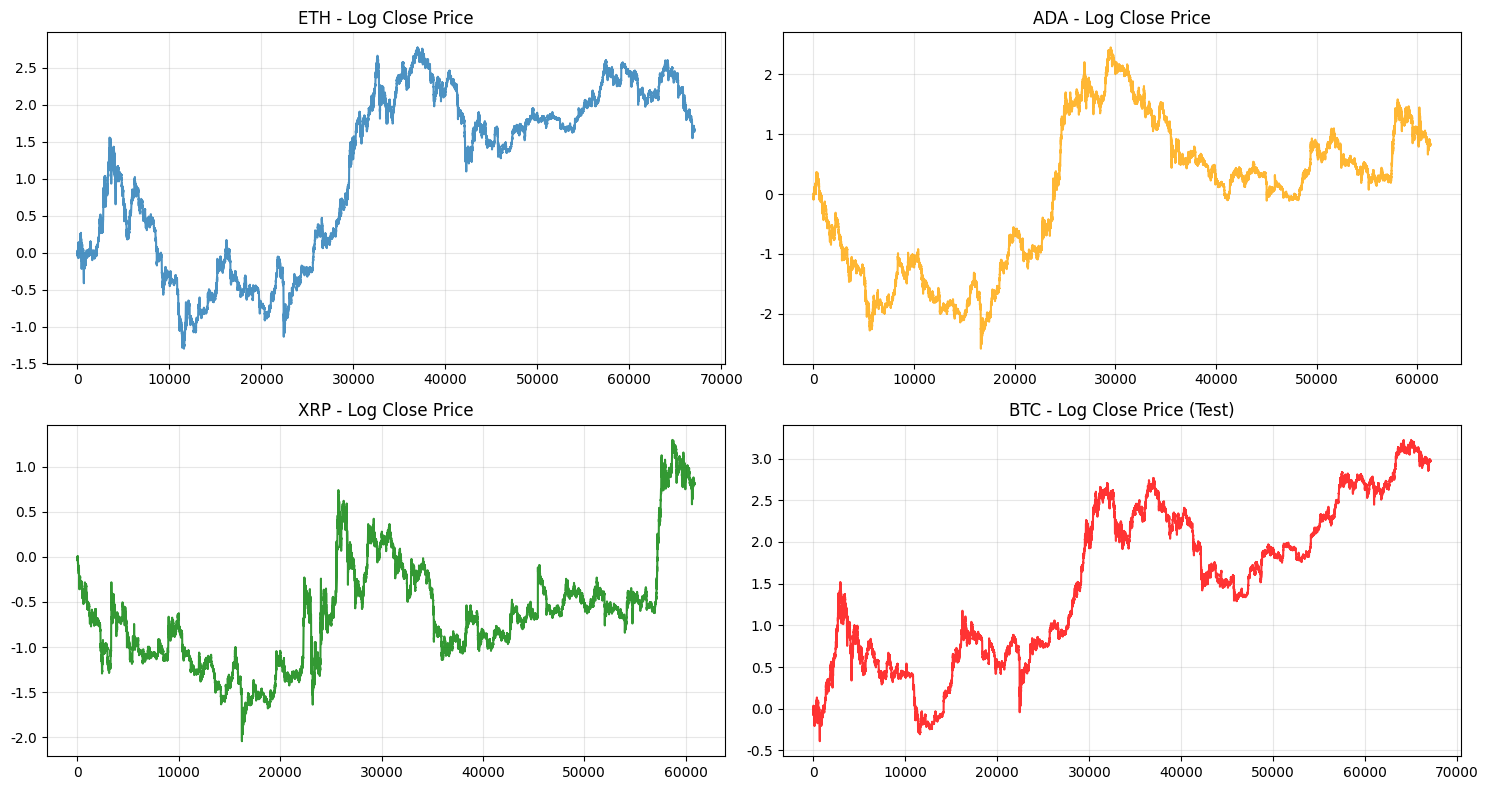

In [7]:
# 피처 이름 정의
feature_names = [
    'log_open', 'log_high', 'log_low', 'log_close', 'volume_norm',
    'rsi', 'adx', 'log_bb_upper', 'log_bb_lower', 'macd_line_norm',
    'macd_signal_norm', 'macd_hist_norm', 'atr_norm', 'vp_current', 'vp_above', 'vp_below'
]

# 각 코인의 종가(log_close) 시각화
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(eth_data[:, 3], label='ETH', alpha=0.8)
plt.title('ETH - Log Close Price')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(ada_data[:, 3], label='ADA', alpha=0.8, color='orange')
plt.title('ADA - Log Close Price')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(xrp_data[:, 3], label='XRP', alpha=0.8, color='green')
plt.title('XRP - Log Close Price')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(btc_data[:, 3], label='BTC', alpha=0.8, color='red')
plt.title('BTC - Log Close Price (Test)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

학습에 사용할 전처리된 데이터를 결합합니다


In [9]:
# 각 코인별로 개별 데이터셋 유지 (결합하지 않음)
datasets = {
    'ETH': eth_data,
    'ADA': ada_data, 
    'XRP': xrp_data
}
test_data = btc_data

print(f"=== 순환학습용 데이터셋 ===")
for name, data in datasets.items():
    print(f"{name}: {data.shape}")
print(f"테스트 (BTC): {test_data.shape}")

# 입력 시퀀스 길이
SEQ_LENGTH = 52
print(f"입력 시퀀스 길이: {SEQ_LENGTH}")

=== 순환학습용 데이터셋 ===
ETH: (67081, 16)
ADA: (61290, 16)
XRP: (60874, 16)
테스트 (BTC): (67081, 16)
입력 시퀀스 길이: 52


In [10]:
def create_sequences(data, seq_length=52):
    """
    시퀀스 생성 함수
    - 입력: seq_length 길이의 시계열 데이터 (52스텝)
    - 출력: 다음 시점의 고가(index 1), 저가(index 2)
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]  # 입력 시퀀스 (52, 16)
        y = [data[i+seq_length, 1], data[i+seq_length, 2]]  # 다음 시점의 [고가, 저가]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 각 코인별 시퀀스 생성
train_sequences = {}
for name, data in datasets.items():
    X, y = create_sequences(data, SEQ_LENGTH)
    train_sequences[name] = (X, y)
    print(f"{name} - X: {X.shape}, y: {y.shape}")

# 테스트 데이터 시퀀스 생성
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)
print(f"Test (BTC) - X: {X_test.shape}, y: {y_test.shape}")

ETH - X: (67029, 52, 16), y: (67029, 2)
ADA - X: (61238, 52, 16), y: (61238, 2)
XRP - X: (60822, 52, 16), y: (60822, 2)
Test (BTC) - X: (67029, 52, 16), y: (67029, 2)


데이터 로더를 준비합니다


In [11]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 128

def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# 각 코인별 DataLoader 생성
train_loaders = {}
for name, (X, y) in train_sequences.items():
    dataset = TensorDataset(to_tensor(X), to_tensor(y))
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_loaders[name] = loader
    print(f"{name} DataLoader: {len(loader)} batches")

# 테스트 DataLoader
test_dataset = TensorDataset(to_tensor(X_test), to_tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Test DataLoader: {len(test_loader)} batches")

print(f"\nBatch size: {BATCH_SIZE}")

ETH DataLoader: 524 batches
ADA DataLoader: 479 batches
XRP DataLoader: 476 batches
Test DataLoader: 524 batches

Batch size: 128


## 2. CNN-Transformer 하이브리드 모델 정의

**모델 구조:**
- **CNN**: 1D 컨볼루션으로 단기 패턴 추출 (16→64 채널)
- **Transformer**: 멀티헤드 어텐션으로 장기 의존성 학습 (8헤드, 3레이어) 
- **출력**: 다음 시점의 [고가, 저가] 예측

**입력:** (batch, 52, 16) → **출력:** (batch, 2)  
**파라미터:** 약 63만개


In [13]:
import torch.nn as nn
import math

class CNNTransformer(nn.Module):
    def __init__(self, input_dim=16, seq_length=52, cnn_channels=64, nhead=8, num_layers=3, d_model=128):
        super().__init__()
        
        # CNN: 1D Convolution for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_channels),
            nn.Conv1d(cnn_channels, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_channels),
            nn.Dropout(0.1)
        )
        
        # Positional Encoding
        self.pos_encoder = nn.Parameter(torch.zeros(1, seq_length, d_model))
        
        # Project CNN output to transformer dimension
        self.input_proj = nn.Linear(cnn_channels, d_model)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model*4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers for [high, low] prediction
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 2)  # 2 outputs: [high, low]
        )

    def forward(self, x):
        # x: (batch, seq, feature) -> (batch, feature, seq)
        x = x.permute(0, 2, 1)
        
        # CNN feature extraction
        x = self.cnn(x)  # (batch, cnn_channels, seq)
        
        # Back to (batch, seq, feature)
        x = x.permute(0, 2, 1)
        
        # Project to transformer dimension and add positional encoding
        x = self.input_proj(x) + self.pos_encoder
        
        # Transformer encoding
        x = self.transformer(x)  # (batch, seq, d_model)
        
        # Use last timestep for prediction
        x = x[:, -1, :]  # (batch, d_model)
        
        # Output: [high, low]
        out = self.fc(x)  # (batch, 2)
        
        return out

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNTransformer().to(device)

# 모델 정보 출력
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"모델이 {device}에 로드되었습니다.")
print(f"총 파라미터 수: {total_params:,}")

모델이 cuda에 로드되었습니다.
총 파라미터 수: 633,922


## 3. 훈련 설정

손실 함수와 옵티마이저, 평가 함수를 정의합니다.


In [14]:
# 손실 함수와 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

print("✅ 훈련 설정 완료:")
print(f"- 손실 함수: {criterion}")
print(f"- 옵티마이저: {optimizer.__class__.__name__}")
print(f"- 학습률 스케줄러: {scheduler.__class__.__name__}")

# 평가 함수
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    return avg_loss

print("✅ 평가 함수 정의 완료")


✅ 훈련 설정 완료:
- 손실 함수: MSELoss()
- 옵티마이저: Adam
- 학습률 스케줄러: ReduceLROnPlateau
✅ 평가 함수 정의 완료


## 4. 순환 훈련 (Curriculum Learning)

각 코인별로 순차적으로 훈련하는 순환 학습을 실시합니다.


In [15]:
# 훈련 설정
NUM_EPOCHS = 10  # 각 코인별 에포크
CYCLES = 3      # 전체 순환 횟수

# 훈련 기록
train_history = {coin: [] for coin in datasets.keys()}
test_history = []

print(f"🚀 순환 훈련 시작!")
print(f"- 각 코인별 에포크: {NUM_EPOCHS}")
print(f"- 순환 횟수: {CYCLES}")
print(f"- 총 훈련 단계: {NUM_EPOCHS * len(datasets) * CYCLES}")

for cycle in range(CYCLES):
    print(f"\n{'='*50}")
    print(f"🔄 순환 {cycle + 1}/{CYCLES}")
    print(f"{'='*50}")
    
    # 각 코인별로 순차 훈련
    for coin_name, data_loader in train_loaders.items():
        print(f"\n📈 {coin_name} 훈련 중...")
        
        for epoch in range(NUM_EPOCHS):
            model.train()
            epoch_loss = 0
            num_batches = 0
            
            for batch_idx, (inputs, targets) in enumerate(data_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
                
                # 배치별 진행상황 출력 (매 100배치마다)
                if (batch_idx + 1) % 100 == 0:
                    avg_loss = epoch_loss / num_batches
                    print(f"  Epoch {epoch+1}/{NUM_EPOCHS}, Batch {batch_idx+1}/{len(data_loader)}, Loss: {avg_loss:.6f}")
            
            # 에포크별 평균 손실
            avg_epoch_loss = epoch_loss / num_batches
            train_history[coin_name].append(avg_epoch_loss)
            
            print(f"  ✅ {coin_name} Epoch {epoch+1} 완료 - Loss: {avg_epoch_loss:.6f}")
        
        # 각 코인 훈련 완료 후 테스트 평가
        test_loss = evaluate_model(model, test_loader, criterion, device)
        test_history.append({'cycle': cycle+1, 'coin': coin_name, 'test_loss': test_loss})
        print(f"  📊 {coin_name} 훈련 후 테스트 손실: {test_loss:.6f}")
        
        # 학습률 조정
        scheduler.step(test_loss)

print(f"\n🎉 순환 훈련 완료!")
print(f"최종 테스트 손실: {test_history[-1]['test_loss']:.6f}")


🚀 순환 훈련 시작!
- 각 코인별 에포크: 10
- 순환 횟수: 3
- 총 훈련 단계: 90

🔄 순환 1/3

📈 ETH 훈련 중...


D:\Temp\ipykernel_20664\1844568759.py:37: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  epoch_loss += loss.item()


  Epoch 1/10, Batch 100/524, Loss: 0.156386
  Epoch 1/10, Batch 200/524, Loss: 0.100408
  Epoch 1/10, Batch 300/524, Loss: 0.077845
  Epoch 1/10, Batch 400/524, Loss: 0.065983
  Epoch 1/10, Batch 500/524, Loss: 0.058312
  ✅ ETH Epoch 1 완료 - Loss: 0.056851
  Epoch 2/10, Batch 100/524, Loss: 0.028092
  Epoch 2/10, Batch 200/524, Loss: 0.026361
  Epoch 2/10, Batch 300/524, Loss: 0.026241
  Epoch 2/10, Batch 400/524, Loss: 0.026774
  Epoch 2/10, Batch 500/524, Loss: 0.026931
  ✅ ETH Epoch 2 완료 - Loss: 0.026594
  Epoch 3/10, Batch 100/524, Loss: 0.021685
  Epoch 3/10, Batch 200/524, Loss: 0.022199
  Epoch 3/10, Batch 300/524, Loss: 0.022376
  Epoch 3/10, Batch 400/524, Loss: 0.022424
  Epoch 3/10, Batch 500/524, Loss: 0.022077
  ✅ ETH Epoch 3 완료 - Loss: 0.022079
  Epoch 4/10, Batch 100/524, Loss: 0.023703
  Epoch 4/10, Batch 200/524, Loss: 0.023549
  Epoch 4/10, Batch 300/524, Loss: 0.022310
  Epoch 4/10, Batch 400/524, Loss: 0.021560
  Epoch 4/10, Batch 500/524, Loss: 0.020687
  ✅ ETH Epoc

## 5. 훈련 결과 시각화

훈련 과정과 결과를 시각화합니다.


IndexError: list index out of range

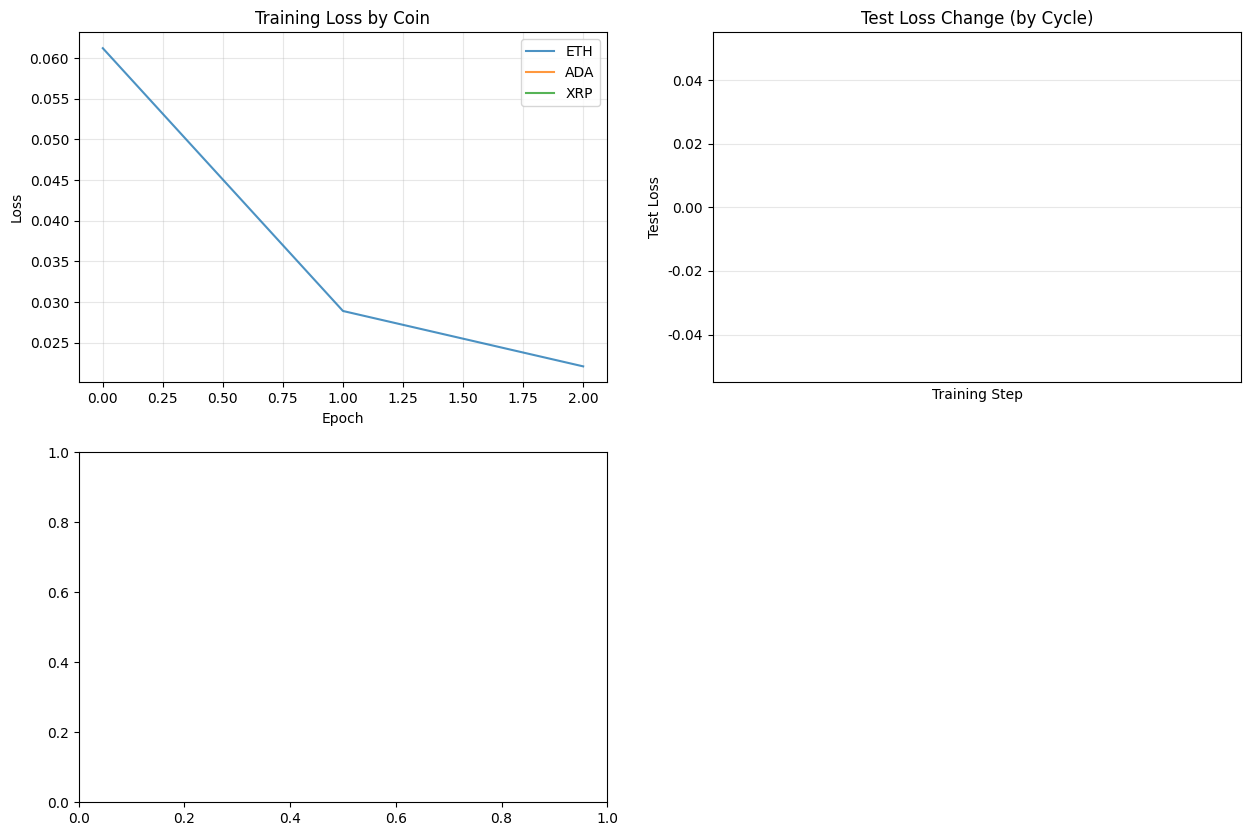

In [14]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')

# Training Loss Visualization
plt.figure(figsize=(15, 10))

# Training loss by coin
plt.subplot(2, 2, 1)
for coin_name, losses in train_history.items():
    plt.plot(losses, label=f'{coin_name}', alpha=0.8)
plt.title('Training Loss by Coin')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Test loss change by cycle
plt.subplot(2, 2, 2)
test_losses = [entry['test_loss'] for entry in test_history]
test_labels = [f"{entry['coin']}-C{entry['cycle']}" for entry in test_history]
plt.plot(test_losses, 'ro-', alpha=0.7)
plt.title('Test Loss Change (by Cycle)')
plt.xlabel('Training Step')
plt.ylabel('Test Loss')
plt.xticks(range(len(test_labels)), test_labels, rotation=45)
plt.grid(True, alpha=0.3)

# Final training loss comparison
plt.subplot(2, 2, 3)
final_losses = [losses[-1] for losses in train_history.values()]
coins = list(train_history.keys())
plt.bar(coins, final_losses, alpha=0.7, color=['blue', 'orange', 'green'])
plt.title('Final Training Loss by Coin')
plt.ylabel('Final Loss')
plt.grid(True, alpha=0.3)

# Overall training process
plt.subplot(2, 2, 4)
all_train_losses = []
labels = []
for coin_name, losses in train_history.items():
    all_train_losses.extend(losses)
    labels.extend([f'{coin_name}-{i+1}' for i in range(len(losses))])

plt.plot(all_train_losses, 'b-', alpha=0.6)
plt.title('Overall Training Process')
plt.xlabel('Total Training Steps')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training results summary
print("\n📊 Training Results Summary:")
print("="*50)
for coin_name, losses in train_history.items():
    print(f"{coin_name}:")
    print(f"  - Initial Loss: {losses[0]:.6f}")
    print(f"  - Final Loss: {losses[-1]:.6f}")
    print(f"  - Improvement: {((losses[0] - losses[-1]) / losses[0] * 100):.2f}%")

print(f"\nFinal Test Loss: {test_history[-1]['test_loss']:.6f}")


## 5.2 예측 성능 분석

실제 BTC 데이터와 모델 예측값을 비교 분석합니다.


In [1]:
# Generate predictions for BTC test data
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(targets.cpu().numpy())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Select a subset for visualization (last 500 data points)
viz_length = 500
if len(predictions) > viz_length:
    pred_subset = predictions[-viz_length:]
    actual_subset = actuals[-viz_length:]
else:
    pred_subset = predictions
    actual_subset = actuals

# Create time series comparison visualization
plt.figure(figsize=(15, 8))

# High price comparison
plt.subplot(2, 1, 1)
plt.plot(actual_subset[:, 0], label='Actual High', color='blue', alpha=0.8, linewidth=1.5)
plt.plot(pred_subset[:, 0], label='Predicted High', color='red', alpha=0.8, linewidth=1.5)
plt.title('BTC High Price: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Log High Price')
plt.legend()
plt.grid(True, alpha=0.3)

# Low price comparison  
plt.subplot(2, 1, 2)
plt.plot(actual_subset[:, 1], label='Actual Low', color='green', alpha=0.8, linewidth=1.5)
plt.plot(pred_subset[:, 1], label='Predicted Low', color='orange', alpha=0.8, linewidth=1.5)
plt.title('BTC Low Price: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Log Low Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate performance metrics
high_mse = np.mean((actual_subset[:, 0] - pred_subset[:, 0]) ** 2)
low_mse = np.mean((actual_subset[:, 1] - pred_subset[:, 1]) ** 2)
high_mae = np.mean(np.abs(actual_subset[:, 0] - pred_subset[:, 0]))
low_mae = np.mean(np.abs(actual_subset[:, 1] - pred_subset[:, 1]))

# Direction accuracy (whether the model predicted the right direction)
high_direction_correct = np.mean(np.sign(np.diff(actual_subset[:, 0])) == np.sign(np.diff(pred_subset[:, 0])))
low_direction_correct = np.mean(np.sign(np.diff(actual_subset[:, 1])) == np.sign(np.diff(pred_subset[:, 1])))

print("\n📊 Prediction Performance Metrics:")
print("="*50)
print(f"High Price:")
print(f"  - MSE: {high_mse:.6f}")
print(f"  - MAE: {high_mae:.6f}")
print(f"  - Direction Accuracy: {high_direction_correct:.1%}")

print(f"\nLow Price:")
print(f"  - MSE: {low_mse:.6f}")
print(f"  - MAE: {low_mae:.6f}")
print(f"  - Direction Accuracy: {low_direction_correct:.1%}")

print(f"\nOverall:")
print(f"  - Average MSE: {(high_mse + low_mse) / 2:.6f}")
print(f"  - Average Direction Accuracy: {(high_direction_correct + low_direction_correct) / 2:.1%}")
print(f"  - Visualization Period: Last {len(pred_subset)} data points")


NameError: name 'model' is not defined

## 6. 모델 저장

훈련된 모델을 저장합니다.


In [13]:
# 모델 저장
import os
from datetime import datetime

# 저장 디렉토리 생성
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)

# 현재 시간으로 모델명 생성
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"{save_dir}/cnn_transformer_{timestamp}.pth"

# 모델 저장 (전체 모델)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_history': train_history,
    'test_history': test_history,
    'model_config': {
        'input_dim': 16,
        'seq_length': 52,
        'cnn_channels': 64,
        'nhead': 8,
        'num_layers': 3,
        'd_model': 128
    }
}, model_path)

print(f"✅ 모델이 저장되었습니다: {model_path}")
print(f"📂 저장 위치: {os.path.abspath(model_path)}")

# 모델 로드 예시 함수
def load_model(model_path, device):
    """저장된 모델을 로드하는 함수"""
    checkpoint = torch.load(model_path, map_location=device)
    
    # 모델 재생성
    model = CNNTransformer(**checkpoint['model_config']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # 옵티마이저 재생성 (필요시)
    optimizer = optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer, checkpoint['train_history'], checkpoint['test_history']

print("\n💡 모델 로드 방법:")
print("model, optimizer, train_hist, test_hist = load_model('모델경로', device)")


✅ 모델이 저장되었습니다: models/cnn_transformer_20250620_154507.pth
📂 저장 위치: d:\Lupheon_v2\models\cnn_transformer_20250620_154507.pth

💡 모델 로드 방법:
model, optimizer, train_hist, test_hist = load_model('모델경로', device)
